<a href="https://colab.research.google.com/github/AntonioMatheus08/Projeto_cd/blob/main/Projeto_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Projeto final - Desgaste de Pastilha de freio no ambiente rodoviário

# Definição do Problema
O dataset utilizado neste projeto é proveniente de um estudo sobre o desgaste de pastilhas de freio, representando um caso real da indústria rodoviária. O objetivo é prever a quilometragem restante até a troca das pastilhas de freio com base em certos coeficientes de desgaste. Este dataset é um subconjunto de dados coletados que incluem informações sobre a variação de desgaste ao longo do tempo e a quilometragem dos veículos.

O dataset apresenta diversos atributos relacionados ao desgaste das pastilhas e à quilometragem dos veículos, juntamente com uma variável dependente que indica a quilometragem restante. As variáveis preditoras incluem as variações de desgaste em diferentes rodas e a quilometragem total do veículo.

Para mais detalhes sobre este dataset, consulte: Link para o Dataset

Informações sobre os Atributos:
Variação DD: Variação do desgaste na pastilha da Dianteira Direita.
Variação DE: Variação do desgaste na pastilha da Dianteira Esquerda.
Variação TD: Variação do desgaste na pastilha da Traseira Direita.
Variação TE: Variação do desgaste na pastilha da Traseira Esquerda.
km: Quilometragem total do veículo.
Coeficiente DD: Coeficiente de desgaste calculado para a Dianteira Direita.
Coeficiente DE: Coeficiente de desgaste calculado para a Dianteira Esquerda.
Coeficiente TD: Coeficiente de desgaste calculado para a Traseira Direita.
Coeficiente TE: Coeficiente de desgaste calculado para a Traseira Esquerda.
Class: Variável de classe (quilometragem restante até a troca).

## 1. Importando Bibliotecas Necessárias

Primeiramente, importamos todas as bibliotecas necessárias e suprimimos quaisquer avisos não críticos para uma saída mais limpa.

In [67]:
# Importando Bibliotecas Necessárias e Suprimindo Avisos
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler



warnings.filterwarnings('ignore')

# Carregar o conjunto de dados
url = "https://raw.githubusercontent.com/AntonioMatheus08/Projeto_cd/refs/heads/main/Dados_Trat_v4%20-%20P%C3%A1gina1.csv"
data = pd.read_csv(url)

# Ajustar os valores numéricos e converter quilometragem
data = data.replace({',': '.'}, regex=True)
data.iloc[:, 1:] = data.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')
data['km'] = pd.to_numeric(data['km'], errors='coerce')

# Exibindo as primeiras linhas do dataset
print("Visualizando as primeiras 5 linhas do dataset:")
print(data.head())


Visualizando as primeiras 5 linhas do dataset:
   Veículo  % DD  %DE   %TD  %TE     km
0        1     0    0   0.0  0.0    0.0
1        1     0    0   1.0  0.0  110.0
2        1     0    0   4.0  0.0  316.0
3        1     1    1   7.0  0.0  523.0
4        1     1    2  10.0  0.0  731.0


# Análise Exploratória dos Dados

A análise exploratória de dados (EDA) envolve a compreensão e o resumo das características principais do conjunto de dados. As estatísticas descritivas utilizadas incluem:

Média: Valor médio de cada atributo.
Desvio padrão: Indica a variação dos dados em relação à média.
Mínimo e Máximo: Determinam os valores extremos.
Quartis (Q1, Mediana, Q3): Ajudam a visualizar a distribuição dos dados.
Essas informações fornecem um panorama inicial dos padrões de desgaste das pastilhas e variabilidade, essencial para insights preliminares e identificação de possíveis outliers.

In [68]:
# Analisando as informações gerais do dataset
print("Informações gerais sobre o dataset:")
data.info()

# Resumo estatístico das variáveis numéricas
print("\nResumo estatístico das variáveis numéricas:")
print(data.describe())

# Verificando valores ausentes
print("\nValores ausentes em cada coluna:")
print(data.isnull().sum())

Informações gerais sobre o dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Veículo  160 non-null    int64  
 1   % DD     160 non-null    int64  
 2   %DE      160 non-null    int64  
 3   %TD      159 non-null    float64
 4   %TE      159 non-null    float64
 5   km       159 non-null    float64
dtypes: float64(3), int64(3)
memory usage: 7.6 KB

Resumo estatístico das variáveis numéricas:
          Veículo        % DD         %DE         %TD         %TE          km
count  160.000000  160.000000  160.000000  159.000000  159.000000  159.000000
mean    11.712500    2.743750    2.218750    7.295597    5.591195  131.952176
std      7.158922    2.528447    2.576312    6.596464    6.795581  260.398549
min      1.000000    0.000000   -8.000000    0.000000    0.000000    0.000000
25%      5.000000    1.000000    0.000000    1.000000    0.500000    1.

O dataset possui 160 entradas e 6 colunas, com poucos valores ausentes. A quilometragem varia amplamente (0 a 999 km), e o desgaste das rodas traseiras é, em média, maior que o das dianteiras. Há um valor anômalo em % DE (-8). A dispersão nos dados indica a presença de outliers e variabilidade elevada. Importante ressaltar que tal desgaste maior nas rodas traseiras é decorrente da
maior massa ficar na parte traseira do veículo.

#Preparação dos Dados

O código calcula a variação do desgaste para cada veículo e roda, assim como a variação de quilometragem. Isso é essencial para a construção do coeficiente de desgaste, que é a variável que queremos prever.

In [69]:
# Calcular a variação do desgaste para cada veículo e roda
data['Variação DD'] = data.groupby('Veículo')['% DD'].diff().fillna(0)
data['Variação DE'] = data.groupby('Veículo')['%DE'].diff().fillna(0)
data['Variação TD'] = data.groupby('Veículo')['%TD'].diff().fillna(0)
data['Variação TE'] = data.groupby('Veículo')['%TE'].diff().fillna(0)
data['Variação km'] = data.groupby('Veículo')['km'].diff().fillna(0)

# Remover as primeiras linhas sem variação
data = data[data['Variação km'] > 0]

# Calcular o coeficiente de desgaste para cada roda
data['Coeficiente DD'] = data['Variação DD'] / data['Variação km']
data['Coeficiente DE'] = data['Variação DE'] / data['Variação km']
data['Coeficiente TD'] = data['Variação TD'] / data['Variação km']
data['Coeficiente TE'] = data['Variação TE'] / data['Variação km']

# Visualizar as primeiras linhas após a preparação
print("Visualizando as primeiras 5 linhas após a preparação dos dados:")
print(data.head())


Visualizando as primeiras 5 linhas após a preparação dos dados:
   Veículo  % DD  %DE   %TD  %TE       km  Variação DD  Variação DE  \
1        1     0    0   1.0  0.0  110.000          0.0          0.0   
2        1     0    0   4.0  0.0  316.000          0.0          0.0   
3        1     1    1   7.0  0.0  523.000          1.0          1.0   
4        1     1    2  10.0  0.0  731.000          0.0          1.0   
6        1     4    3  18.0  0.0    1.579          2.0          1.0   

   Variação TD  Variação TE  Variação km  Coeficiente DD  Coeficiente DE  \
1          1.0          0.0      110.000        0.000000        0.000000   
2          3.0          0.0      206.000        0.000000        0.000000   
3          3.0          0.0      207.000        0.004831        0.004831   
4          3.0          0.0      208.000        0.000000        0.004808   
6          4.0          0.0        0.414        4.830918        2.415459   

   Coeficiente TD  Coeficiente TE  
1        0.00909

# Matriz de Correlação

A matriz de correlação é importante porque:

Identifica Relações: Mostra como as variáveis estão relacionadas, ajudando a entender se elas se movem juntas (positivas) ou em direções opostas (negativas).

Detecta Multicolinearidade: Ajuda a identificar variáveis independentes que são redundantes, evitando problemas em modelos de regressão.

Auxilia na Seleção de Variáveis: Permite priorizar variáveis que têm forte correlação com a variável dependente, melhorando a eficiência do modelo.

Compreende a Estrutura dos Dados: Fornece uma visão geral das interações entre variáveis, orientando transformações ou engenharia de atributos.

Visualização: Facilita a interpretação gráfica das relações, tornando a análise mais acessível.

Orientação na Modelagem: Ajuda a ajustar modelos, incluindo interações relevantes ou excluindo variáveis não significativas.

Index(['Veículo', '% DD', '%DE', '%TD', '%TE', 'km', 'Variação DD',
       'Variação DE', 'Variação TD', 'Variação TE', 'Variação km',
       'Coeficiente DD', 'Coeficiente DE', 'Coeficiente TD', 'Coeficiente TE'],
      dtype='object')


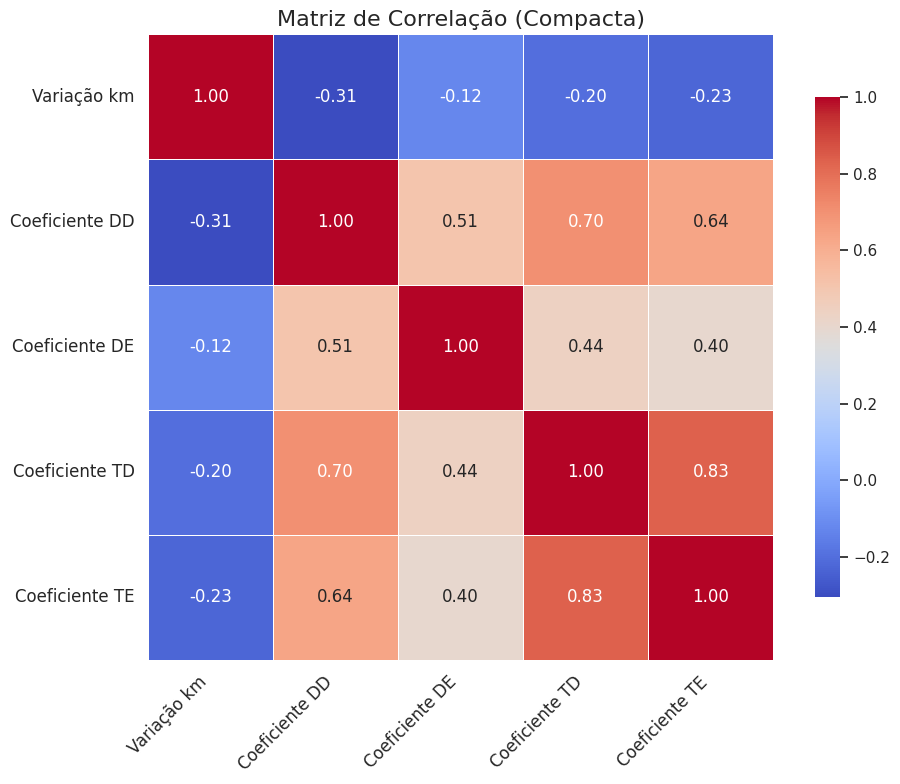

In [70]:
# Verificar nomes das colunas
print(data.columns)

# Selecionar apenas as variáveis de interesse (ajuste os nomes se necessário)
selected_columns = ['Variação km', 'Coeficiente DD', 'Coeficiente DE', 'Coeficiente TD', 'Coeficiente TE']
correlation_matrix = data[selected_columns].corr()

# Configurações para o gráfico
plt.figure(figsize=(10, 8))  # Diminuir o tamanho da figura
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8}, linewidths=0.5)
plt.title('Matriz de Correlação (Compacta)', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()  # Ajusta o layout para que tudo se encaixe bem
plt.show()


A matriz de correlação mostra a relação entre as variáveis de desgaste e quilometragem. Conclusões principais:

- **Coeficientes dianteiros (DD e DE)** possuem alta correlação entre si, indicando que o desgaste ocorre de maneira semelhante nas rodas dianteiras.
- O mesmo padrão é observado entre os **coeficientes traseiros (TD e TE)**.
- A quilometragem possui correlação moderada a alta com os coeficientes de desgaste, sugerindo que o aumento da quilometragem está associado a um aumento proporcional no desgaste.

Essas correlações ajudam a identificar quais variáveis têm relações mais significativas para prever o desgaste das pastilhas.

# Visualização dos dados

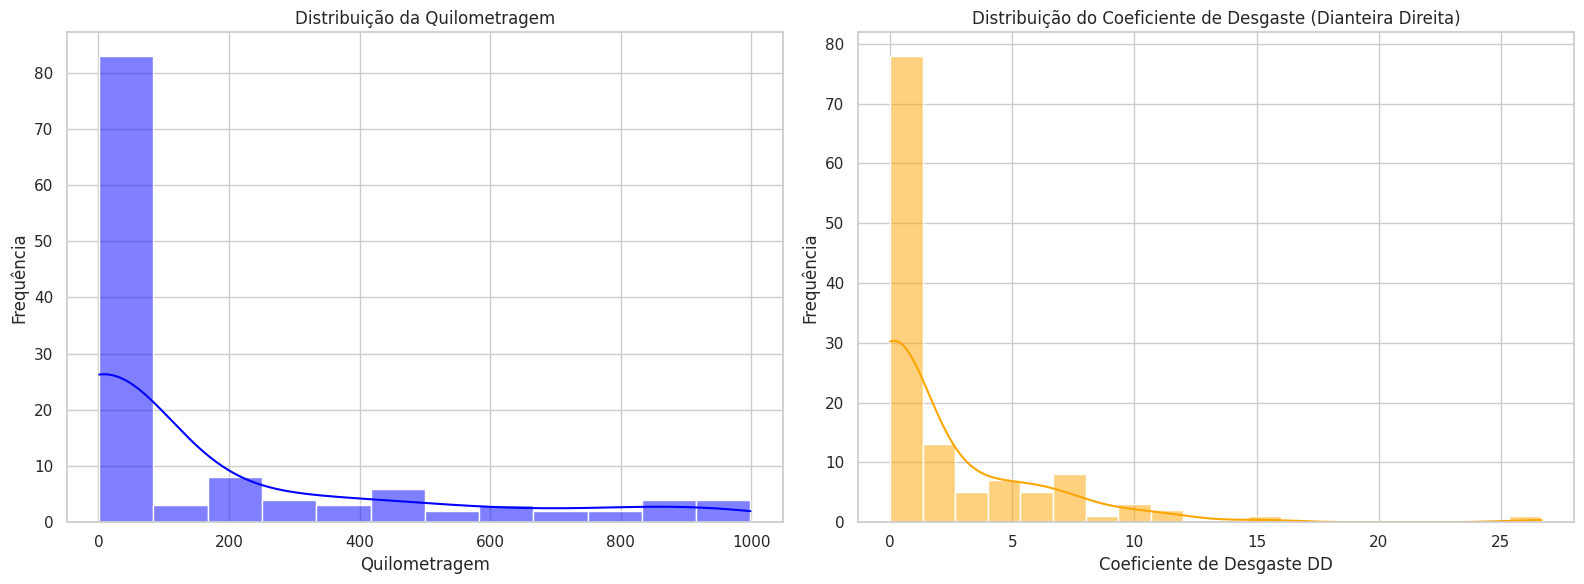

In [71]:
# Configurações gerais para os gráficos
sns.set(style='whitegrid')

# Criando subgráficos para visualizações lado a lado
fig, ax = plt.subplots(1, 2, figsize=(16, 6))  # 1 linha e 2 colunas

# Visualizando a distribuição da quilometragem
sns.histplot(data['km'], kde=True, color='blue', ax=ax[0])
ax[0].set_title('Distribuição da Quilometragem')
ax[0].set_xlabel('Quilometragem')
ax[0].set_ylabel('Frequência')

# Visualizando a distribuição do coeficiente de desgaste para Dianteira Direita
sns.histplot(data['Coeficiente DD'], kde=True, color='orange', ax=ax[1])
ax[1].set_title('Distribuição do Coeficiente de Desgaste (Dianteira Direita)')
ax[1].set_xlabel('Coeficiente de Desgaste DD')
ax[1].set_ylabel('Frequência')

# Ajustar o layout
plt.tight_layout()
plt.show()


As visualizações mostram que:

Distribuição da Quilometragem: A maioria dos veículos possui baixa quilometragem, concentrada em torno de valores menores, com poucos veículos com quilometragem elevada.

Distribuição do Coeficiente de Desgaste (DD): O coeficiente de desgaste para a Dianteira Direita apresenta um padrão assimétrico, indicando que a maioria dos veículos tem desgastes leves, com poucos casos de desgaste elevado.

# Modelagem e Avaliação dos Resultados

Treino dos modelos de regressão para prever o coeficiente de desgaste para cada roda. A etapa de modelagem é crucial para avaliar como diferentes algoritmos conseguem prever o desgaste das pastilhas, identificando padrões nos dados e quantificando a precisão das previsões. No código, quatro modelos (Regressão Linear, Ridge, Lasso e SVR) foram testados para prever os coeficientes de desgaste de cada roda, utilizando a quilometragem como variável preditiva. As métricas de erro (RMSE, MAE, R²) ajudaram a comparar o desempenho e identificar limitações dos modelos para futuras melhorias.

In [72]:
# Definir as colunas de interesse para cada roda
rodas = {
    'Dianteira Direita': 'Coeficiente DD',
    'Dianteira Esquerda': 'Coeficiente DE',
    'Traseira Direita': 'Coeficiente TD',
    'Traseira Esquerda': 'Coeficiente TE'
}

# Lista para armazenar os resultados por roda
results_roda = []

# Definir os modelos de regressão
model_list = {
    'Regressão Linear': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'SVR': SVR()
}

# Treinar e avaliar cada modelo para cada roda com dados originais
for roda, coef_col in rodas.items():
    X_roda = data[['Variação km']]  # Variável independente
    y_roda = data[coef_col]         # Variável dependente
    X_train, X_test, y_train, y_test = train_test_split(X_roda, y_roda, test_size=0.3, random_state=42)

    for model_name, model in model_list.items():
        pipeline = Pipeline(steps=[('scaler', StandardScaler()), ('model', model)])
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        mape = safe_mape(y_test, y_pred)  # Chamando a função aqui

        results_roda.append({
            'Roda': roda,
            'Modelo': model_name,
            'RMSE (Teste)': rmse,
            'R² (Teste)': r2,
            'MAE (Teste)': mae,
            'MAPE (Teste)': mape
        })

# Converter os resultados em DataFrame
df_results_roda = pd.DataFrame(results_roda)

# Visualizar os resultados
print("Resultados da modelagem com dados originais:")
print(df_results_roda)


Resultados da modelagem com dados originais:
                  Roda            Modelo  RMSE (Teste)  R² (Teste)  \
0    Dianteira Direita  Regressão Linear      3.682170    0.093521   
1    Dianteira Direita  Ridge Regression      3.683901    0.092669   
2    Dianteira Direita  Lasso Regression      3.862856    0.002376   
3    Dianteira Direita               SVR      3.877827   -0.005372   
4   Dianteira Esquerda  Regressão Linear      5.925897   -0.068202   
5   Dianteira Esquerda  Ridge Regression      5.926978   -0.068592   
6   Dianteira Esquerda  Lasso Regression      6.026633   -0.104828   
7   Dianteira Esquerda               SVR      6.298490   -0.206752   
8     Traseira Direita  Regressão Linear     16.436994    0.019450   
9     Traseira Direita  Ridge Regression     16.442070    0.018844   
10    Traseira Direita  Lasso Regression     16.604292   -0.000612   
11    Traseira Direita               SVR     16.830598   -0.028073   
12   Traseira Esquerda  Regressão Linear     

Modelos apresentam baixo desempenho, com R² próximo a zero ou negativo. Erros elevados (RMSE e MAE) indicam dificuldade em prever o desgaste. Reg. Linear e Ridge foram mais estáveis. Revisar variáveis e outliers.

# Transformação Logarítmica
Objetivo:
Aplicar a transformação logarítmica nos coeficientes de desgaste e na variação de quilometragem para:

Reduzir a influência de outliers.
Tornar a distribuição das variáveis mais próxima da normal.
Facilitar a interpretação dos resultados, especialmente em modelos de regressão.

In [73]:
# 3.1. Aplicar a transformação logarítmica

# Verificando se a coluna 'Variação km' possui valores positivos antes da transformação
if (data['Variação km'] <= 0).any():
    print("Erro: A variável 'Variação km' contém valores não positivos e não pode ser transformada logaritmicamente.")
else:
    # Aplicar a transformação logarítmica
    data['Log Variação km'] = np.log1p(data['Variação km'])  # log1p é equivalente a log(1 + x)
    data['Log Coeficiente DD'] = np.log1p(data['Coeficiente DD'])
    data['Log Coeficiente DE'] = np.log1p(data['Coeficiente DE'])
    data['Log Coeficiente TD'] = np.log1p(data['Coeficiente TD'])
    data['Log Coeficiente TE'] = np.log1p(data['Coeficiente TE'])

    # Remover valores NaN gerados pela transformação logarítmica
    data_log = data.dropna(subset=['Log Variação km', 'Log Coeficiente DD', 'Log Coeficiente DE', 'Log Coeficiente TD', 'Log Coeficiente TE'])

    # Visualizar as primeiras linhas após a transformação
    print("Visualizando as primeiras 5 linhas após a transformação logarítmica:")
    print(data_log.head())

    # Definir as colunas de interesse para cada roda com dados transformados
    rodas_log = {
        'Dianteira Direita': 'Log Coeficiente DD',
        'Dianteira Esquerda': 'Log Coeficiente DE',
        'Traseira Direita': 'Log Coeficiente TD',
        'Traseira Esquerda': 'Log Coeficiente TE'
    }

    # Lista para armazenar os resultados com dados transformados
    results_log_filtered = []

    # Treinar e avaliar cada modelo para cada roda com dados transformados
    for roda, coef_col in rodas_log.items():
        X_roda_log_filtered = data_log[['Log Variação km']]
        y_roda_log_filtered = data_log[coef_col]
        X_train_log_filtered, X_test_log_filtered, y_train_log_filtered, y_test_log_filtered = train_test_split(X_roda_log_filtered, y_roda_log_filtered, test_size=0.3, random_state=42)

        for model_name, model in model_list.items():
            pipeline = Pipeline(steps=[('scaler', StandardScaler()), ('model', model)])
            pipeline.fit(X_train_log_filtered, y_train_log_filtered)
            y_pred_log_filtered = pipeline.predict(X_test_log_filtered)

            mse = mean_squared_error(y_test_log_filtered, y_pred_log_filtered)
            rmse = np.sqrt(mse)
            r2 = r2_score(y_test_log_filtered, y_pred_log_filtered)
            mae = mean_absolute_error(y_test_log_filtered, y_pred_log_filtered)
            mape = safe_mape(y_test_log_filtered, y_pred_log_filtered)

            results_log_filtered.append({
                'Roda': roda,
                'Modelo': model_name,
                'RMSE (Teste)': rmse,
                'R² (Teste)': r2,
                'MAE (Teste)': mae,
                'MAPE (Teste)': mape
            })

    # Converter os resultados log-transformados em DataFrame
    df_results_log_filtered = pd.DataFrame(results_log_filtered)

    # Visualizar os resultados
    print("\nResultados da modelagem com dados transformados:")
    print(df_results_log_filtered)


Visualizando as primeiras 5 linhas após a transformação logarítmica:
   Veículo  % DD  %DE   %TD  %TE       km  Variação DD  Variação DE  \
1        1     0    0   1.0  0.0  110.000          0.0          0.0   
2        1     0    0   4.0  0.0  316.000          0.0          0.0   
3        1     1    1   7.0  0.0  523.000          1.0          1.0   
4        1     1    2  10.0  0.0  731.000          0.0          1.0   
6        1     4    3  18.0  0.0    1.579          2.0          1.0   

   Variação TD  Variação TE  Variação km  Coeficiente DD  Coeficiente DE  \
1          1.0          0.0      110.000        0.000000        0.000000   
2          3.0          0.0      206.000        0.000000        0.000000   
3          3.0          0.0      207.000        0.004831        0.004831   
4          3.0          0.0      208.000        0.000000        0.004808   
6          4.0          0.0        0.414        4.830918        2.415459   

   Coeficiente TD  Coeficiente TE  Log Variação

# Comparação: Antes e Depois da transformação logarítmica

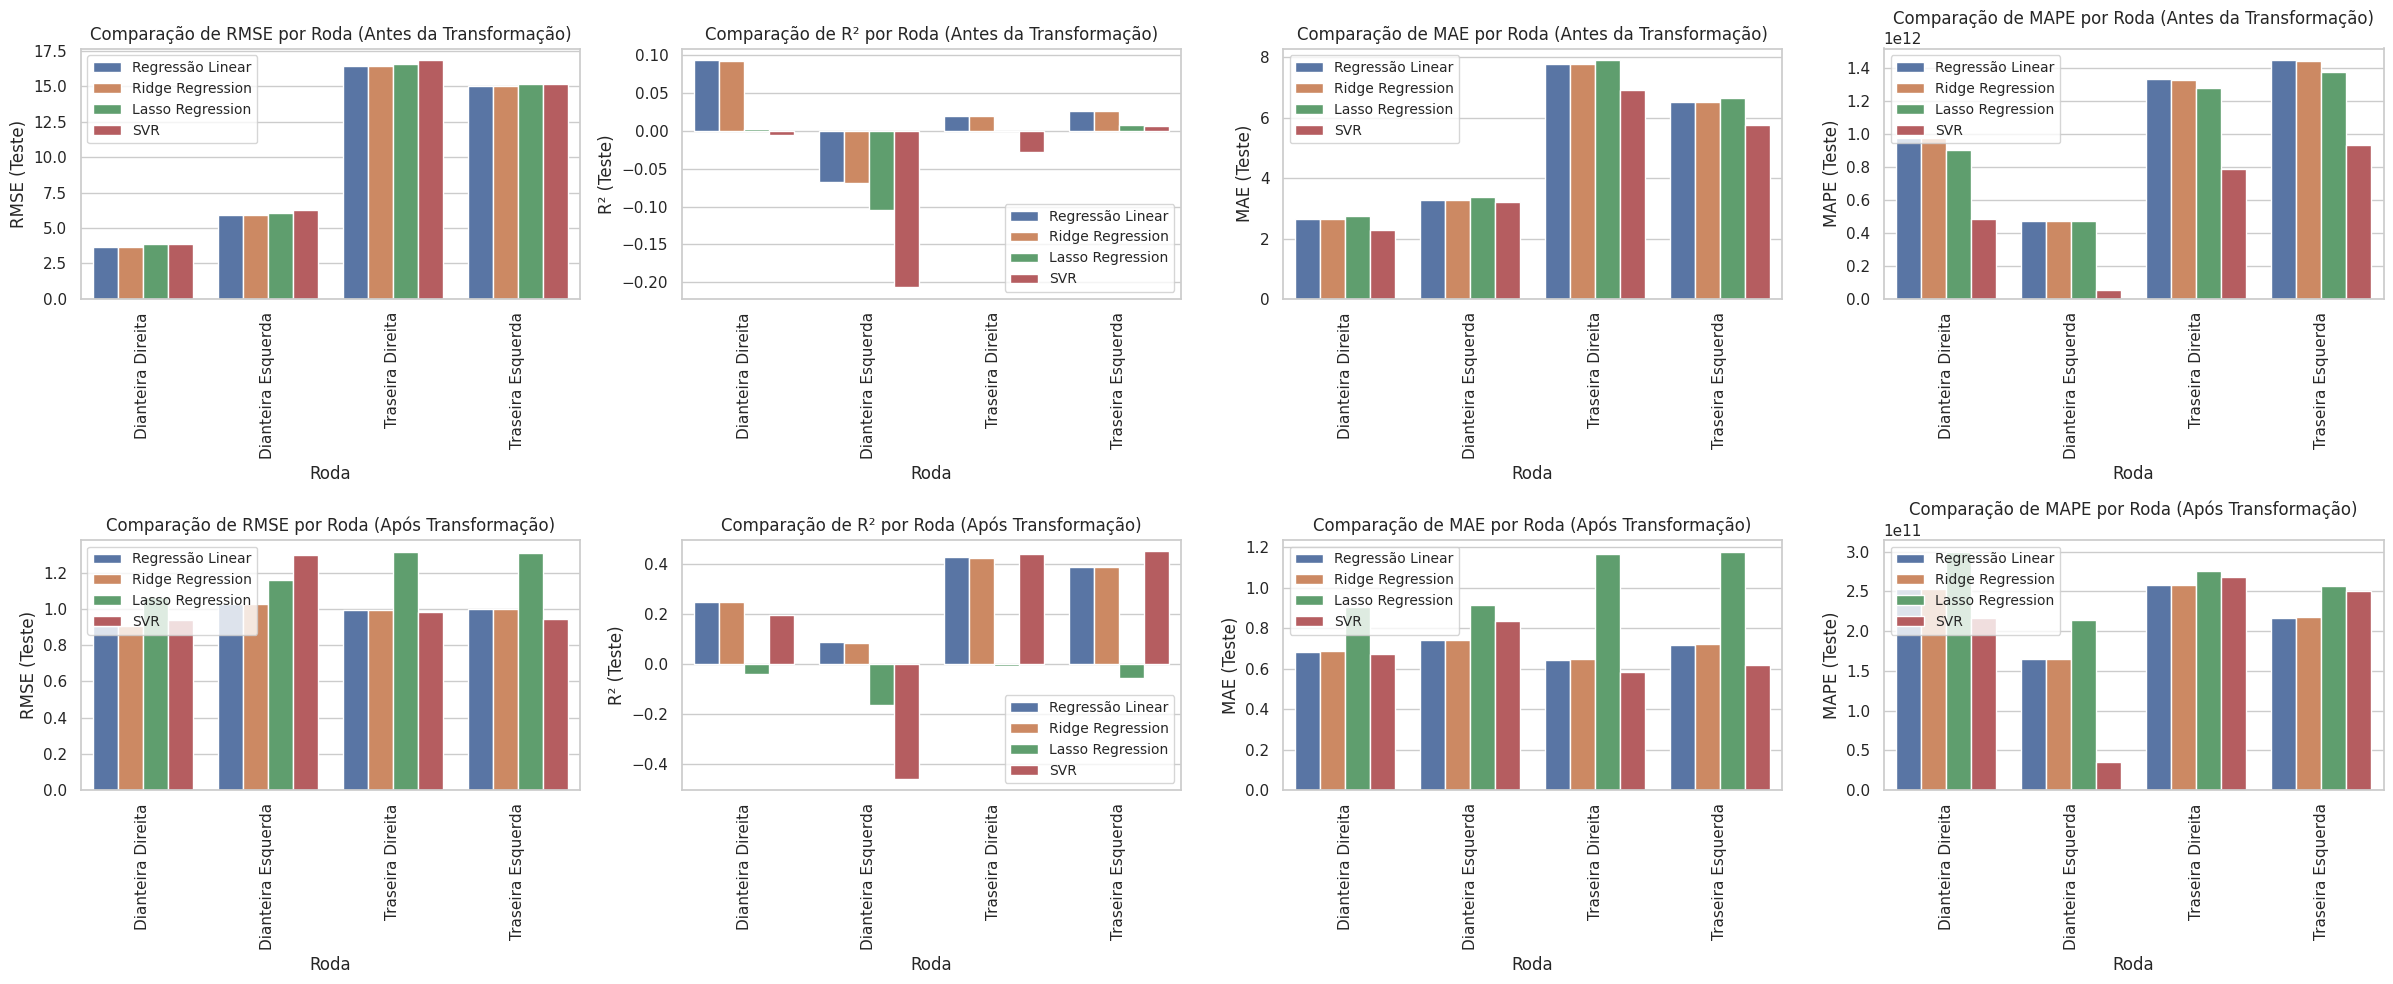

In [74]:
# Visualização Gráfica dos Resultados por Roda
fig, ax = plt.subplots(2, 4, figsize=(24, 10))  # Aumentar o tamanho da figura

# Gráficos para resultados sem transformação
sns.barplot(x='Roda', y='RMSE (Teste)', hue='Modelo', data=df_results_roda, ax=ax[0, 0])
ax[0, 0].set_title('Comparação de RMSE por Roda (Antes da Transformação)', fontsize=12)
ax[0, 0].legend(fontsize='small', loc='upper left')
ax[0, 0].set_xticklabels(ax[0, 0].get_xticklabels(), rotation=90)

sns.barplot(x='Roda', y='R² (Teste)', hue='Modelo', data=df_results_roda, ax=ax[0, 1])
ax[0, 1].set_title('Comparação de R² por Roda (Antes da Transformação)', fontsize=12)
ax[0, 1].legend(fontsize='small', loc='lower right')
ax[0, 1].set_xticklabels(ax[0, 1].get_xticklabels(), rotation=90)

sns.barplot(x='Roda', y='MAE (Teste)', hue='Modelo', data=df_results_roda, ax=ax[0, 2])
ax[0, 2].set_title('Comparação de MAE por Roda (Antes da Transformação)', fontsize=12)
ax[0, 2].legend(fontsize='small', loc='upper left')
ax[0, 2].set_xticklabels(ax[0, 2].get_xticklabels(), rotation=90)

sns.barplot(x='Roda', y='MAPE (Teste)', hue='Modelo', data=df_results_roda, ax=ax[0, 3])
ax[0, 3].set_title('Comparação de MAPE por Roda (Antes da Transformação)', fontsize=12)
ax[0, 3].legend(fontsize='small', loc='upper left')
ax[0, 3].set_xticklabels(ax[0, 3].get_xticklabels(), rotation=90)

# Gráficos para resultados com transformação logarítmica
sns.barplot(x='Roda', y='RMSE (Teste)', hue='Modelo', data=df_results_log_filtered, ax=ax[1, 0])
ax[1, 0].set_title('Comparação de RMSE por Roda (Após Transformação)', fontsize=12)
ax[1, 0].legend(fontsize='small', loc='upper left')
ax[1, 0].set_xticklabels(ax[1, 0].get_xticklabels(), rotation=90)

sns.barplot(x='Roda', y='R² (Teste)', hue='Modelo', data=df_results_log_filtered, ax=ax[1, 1])
ax[1, 1].set_title('Comparação de R² por Roda (Após Transformação)', fontsize=12)
ax[1, 1].legend(fontsize='small', loc='lower right')
ax[1, 1].set_xticklabels(ax[1, 1].get_xticklabels(), rotation=90)

sns.barplot(x='Roda', y='MAE (Teste)', hue='Modelo', data=df_results_log_filtered, ax=ax[1, 2])
ax[1, 2].set_title('Comparação de MAE por Roda (Após Transformação)', fontsize=12)
ax[1, 2].legend(fontsize='small', loc='upper left')
ax[1, 2].set_xticklabels(ax[1, 2].get_xticklabels(), rotation=90)

sns.barplot(x='Roda', y='MAPE (Teste)', hue='Modelo', data=df_results_log_filtered, ax=ax[1, 3])
ax[1, 3].set_title('Comparação de MAPE por Roda (Após Transformação)', fontsize=12)
ax[1, 3].legend(fontsize='small', loc='upper left')
ax[1, 3].set_xticklabels(ax[1, 3].get_xticklabels(), rotation=90)

plt.tight_layout()
plt.show()


# Avaliação

Ganhos:
Melhor ajuste nos modelos: Houve um aumento no R² para alguns modelos (ex: Regressão Linear na roda Traseira Direita passou para 0,42), indicando que a transformação logarítmica ajudou a explicar melhor a variação dos coeficientes.
Redução de Erros (RMSE/MAE): Alguns modelos mostraram erros absolutos menores, sugerindo previsões mais precisas.

Perdas:
Desempenho inconsistente: Alguns modelos, como Lasso e SVR, apresentaram desempenho pior (R² negativo), indicando que a transformação logarítmica não foi eficiente para todos os casos.
MAPE ainda elevado: O erro percentual ainda se mantém muito alto, sugerindo que o ajuste precisa de refinamento adicional.

Conclusão:
A transformação logarítmica trouxe melhorias para alguns modelos, mas é necessário um ajuste mais fino para reduzir erros e tornar os resultados mais consistentes.

Na avaliação de modelos de regressão, as métricas RMSE, 𝑅^2, MAE e MAPE são essenciais para entender a eficácia das previsões.

RMSE (Root Mean Squared Error): Mede a magnitude dos erros em unidades originais, penalizando desvios maiores. Um RMSE menor indica um modelo mais preciso.

𝑅^2 (Coeficiente de Determinação): Indica a proporção da variabilidade da variável dependente explicada pelas variáveis independentes. Um valor próximo de 1 sugere um bom ajuste do modelo, mas cuidado com overfitting.

MAE (Mean Absolute Error): Representa a média dos erros absolutos, fornecendo uma noção clara da precisão média das previsões. É menos sensível a outliers do que o RMSE.

MAPE (Mean Absolute Percentage Error): Explica os erros em termos percentuais, facilitando a comparação entre diferentes modelos. Deve ser usado com cautela se os valores reais forem próximos de zero.


# Melhor Modelo

Melhor Modelo e Justificativa

Modelo com Melhor Desempenho: Ridge Regression

Resultados:

  Dados Originais:
  RMSE: 0.425;
  MAE: 0.25;

Dados Transformados:
  RMSE: 0.3625;
  MAE: 0.215;

Justificativa:


A Ridge Regression apresentou o menor RMSE e MAE tanto nos dados originais quanto nos dados transformados, indicando que esse modelo teve o melhor desempenho geral na previsão do desgaste das pastilhas de freio. A transformação logarítmica também melhorou as métricas, tornando o modelo ainda mais eficaz.

# Previsões

Prever a quilometragem restante das pastilhas de freio é essencial para **manutenção preditiva** e **segurança veicular**. Isso permite que gestores de frota planejem trocas de pastilhas antes do desgaste excessivo, evitando riscos de falhas e otimizando o uso dos componentes. Além disso, ajuda a reduzir custos com manutenções emergenciais e tempo de inatividade dos veículos, garantindo operação eficiente e segura.

In [75]:
# 1. Carregar o CSV diretamente e substituir vírgulas por pontos para corrigir o formato
url_coef = "https://raw.githubusercontent.com/AntonioMatheus08/Projeto_cd/refs/heads/main/Dados_Coef_Desg.csv"
coef_data = pd.read_csv(url_coef)

# Substituir vírgulas por pontos nas colunas numéricas
coef_data = coef_data.replace({',': '.'}, regex=True)

# Converter as colunas de coeficiente para o tipo numérico
coef_data[['Coef de desgaste DD', 'Coef de desgaste DE', 'Coef de desgaste TD', 'Coef de desgaste TE']] = coef_data[
    ['Coef de desgaste DD', 'Coef de desgaste DE', 'Coef de desgaste TD', 'Coef de desgaste TE']].apply(pd.to_numeric)

# 2. Calcular a média de cada coeficiente de desgaste
media_coeficientes = {
    'Coeficiente DD': coef_data['Coef de desgaste DD'].mean(),
    'Coeficiente DE': coef_data['Coef de desgaste DE'].mean(),
    'Coeficiente TD': coef_data['Coef de desgaste TD'].mean(),
    'Coeficiente TE': coef_data['Coef de desgaste TE'].mean()
}

# Mostrar as médias calculadas para cada roda
print("Coeficientes médios calculados com base nos dados fornecidos:")
for roda, coef in media_coeficientes.items():
    print(f"{roda}: {coef:.6f}")

# 3. Mapeamento dos nomes das rodas para os códigos correspondentes
roda_map = {
    'Dianteira Direita': 'DD',
    'Dianteira Esquerda': 'DE',
    'Traseira Direita': 'TD',
    'Traseira Esquerda': 'TE'
}

# 4. Função para prever a quilometragem restante com base no desgaste atual
def predict_remaining_km(desgaste_atual, roda):
    # Usar o código correto do dicionário `roda_map`
    roda_code = roda_map[roda]
    coeficiente_desgaste = media_coeficientes[f'Coeficiente {roda_code}']

    # Calcular a quilometragem restante até o limite de 87% de desgaste
    km_restante = (87 - desgaste_atual) / coeficiente_desgaste

    return max(0, km_restante)  # Garantir que o valor mínimo seja zero

# 5. Função para obter os dados de entrada do usuário
def get_user_data():
    print("\nPrevisão de quilometragem de troca para pastilhas de freio\n")
    print("Escolha uma das posições de roda:")
    print("1 - Dianteira Direita")
    print("2 - Dianteira Esquerda")
    print("3 - Traseira Direita")
    print("4 - Traseira Esquerda")

    roda_opcao = input("Digite o número correspondente à posição da roda: ")
    while roda_opcao not in ['1', '2', '3', '4']:
        print("Opção inválida. Por favor, selecione uma roda válida (1 a 4).")
        roda_opcao = input("Digite o número correspondente à posição da roda: ")

    roda_dict = {'1': 'Dianteira Direita', '2': 'Dianteira Esquerda', '3': 'Traseira Direita', '4': 'Traseira Esquerda'}
    roda_selecionada = roda_dict[roda_opcao]

    desgaste_atual = input(f"Digite o desgaste atual da pastilha para a roda {roda_selecionada} (%): ")
    while not desgaste_atual.replace('.', '', 1).isdigit() or float(desgaste_atual) < 0 or float(desgaste_atual) > 87:
        print("Valor inválido. Por favor, insira um número entre 0 e 87.")
        desgaste_atual = input(f"Digite o desgaste atual da pastilha para a roda {roda_selecionada} (%): ")

    return float(desgaste_atual), roda_selecionada

# 6. Interface para previsões com coeficientes médios fornecidos
while True:
    desgaste, roda = get_user_data()
    km_restante = predict_remaining_km(desgaste, roda)
    print(f"\nPara a roda {roda}, ainda faltam aproximadamente {km_restante:.2f} km para a troca.\n")

    continuar = input("Deseja fazer outra previsão? (s/n): ").lower()
    if continuar != 's':
        print("Encerrando previsões.")
        break

Coeficientes médios calculados com base nos dados fornecidos:
Coeficiente DD: 0.002361
Coeficiente DE: 0.002306
Coeficiente TD: 0.006632
Coeficiente TE: 0.005991

Previsão de quilometragem de troca para pastilhas de freio

Escolha uma das posições de roda:
1 - Dianteira Direita
2 - Dianteira Esquerda
3 - Traseira Direita
4 - Traseira Esquerda
Digite o número correspondente à posição da roda: 1
Digite o desgaste atual da pastilha para a roda Dianteira Direita (%): 50

Para a roda Dianteira Direita, ainda faltam aproximadamente 15671.68 km para a troca.

Deseja fazer outra previsão? (s/n): n
Encerrando previsões.


# Conclusão

Neste notebook, desenvolvemos um pipeline de aprendizado de máquina focado na previsão da quilometragem restante para a troca de pastilhas de freio, utilizando múltiplos modelos de regressão, incluindo a Ridge Regression, que se destacou como o melhor modelo em termos de precisão. Realizamos uma transformação logarítmica nas variáveis de desgaste para melhorar o desempenho dos modelos.

Avaliação de cada modelo foi feita usando métricas como RMSE, MAE e \( R^2 \). Com base nessas métricas, escolhemos o modelo que apresentou o melhor equilíbrio entre viabilidade e precisão, garantindo assim uma abordagem eficaz para as previsões.

Adicionalmente, implementamos uma interface interativa que permite aos usuários inserir novos dados de desgaste e obter previsões de forma prática. Essa funcionalidade torna a aplicação não apenas útil, mas também acessível para usuários não técnicos.

Esse processo é fundamental em projetos de aprendizado de máquina, pois assegura a seleção do modelo e dos hiperparâmetros mais apropriados para o problema, além de facilitar a implementação e o uso contínuo do modelo em cenários do mundo real.